# Convolution

This notebook demonstrates *convolution matrix* (aka. *kernel*). See: https://en.wikipedia.org/wiki/Kernel_(image_processing)

## Load a sample image (via Pillow: a fork of Python Image Library (PIL))

In [3]:
from PIL import Image
import urllib.request

In [4]:
img = Image.open(urllib.request.urlopen('https://chokkan.github.io/deeplearning/assets/images/sheep.jpg'))
img.thumbnail((256,256), Image.Resampling.LANCZOS) # Resize to half to reduce the size of this notebook.

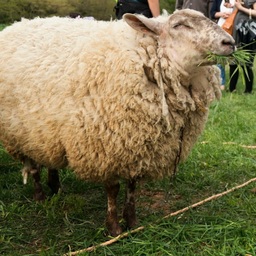

In [5]:
img

## Convert the image into torch.tensor

In [6]:
import torch, torchvision
from torchvision import transforms
from torch import nn

Define utility functions to bridge images and tensors.

In [7]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

Convert the PIL image object into a torch tensor.

In [8]:
input = to_tensor(img)

The shape of `input` is (channel, width, height).

In [9]:
input.shape

torch.Size([1, 256, 256])

In [10]:
input

tensor([[[0.3490, 0.3725, 0.3412,  ..., 0.4118, 0.4039, 0.3725],
         [0.3843, 0.3765, 0.3725,  ..., 0.3843, 0.2824, 0.2314],
         [0.3529, 0.3569, 0.3765,  ..., 0.2275, 0.2471, 0.4118],
         ...,
         [0.1255, 0.0824, 0.1333,  ..., 0.4353, 0.5294, 0.1843],
         [0.2627, 0.2196, 0.1647,  ..., 0.3961, 0.4431, 0.3216],
         [0.2275, 0.3020, 0.3412,  ..., 0.2667, 0.3882, 0.3922]]])

Confirm that we can convert back to the original image from the tensor.

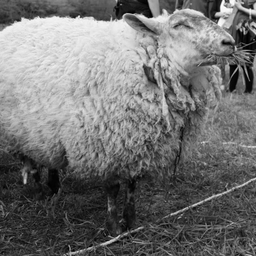

In [11]:
to_pil(input)

## Convolution layer

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [12]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

The code below does not work because the convolution layer requires the dimension for batch.

In [13]:
conv(input)

tensor([[[-0.2926, -0.2394, -0.2374,  ..., -0.2411, -0.1951, -0.0413],
         [-0.3355, -0.3716, -0.3697,  ..., -0.3215, -0.3413, -0.2535],
         [-0.3257, -0.3640, -0.3555,  ..., -0.3666, -0.4909, -0.2460],
         ...,
         [-0.2038, -0.1683, -0.1778,  ..., -0.4509, -0.3893, -0.1696],
         [-0.2139, -0.2105, -0.2160,  ..., -0.3726, -0.4501, -0.2085],
         [-0.1328, -0.1911, -0.1597,  ..., -0.2271, -0.2721, -0.1719]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [14]:
input = input.unsqueeze(0)

In [15]:
input.shape

torch.Size([1, 1, 256, 256])

In [16]:
output = conv(input)

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [17]:
output.shape

torch.Size([1, 1, 256, 256])

We need to remove the first dimension before converting to a PIL object.

In [18]:
output.data.squeeze(dim=0).shape

torch.Size([1, 256, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

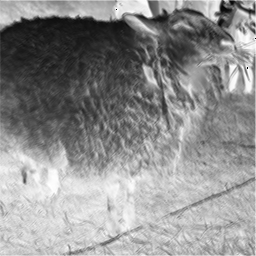

In [19]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

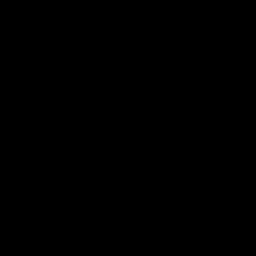

In [20]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

Utility function to show two images in a row.

In [21]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

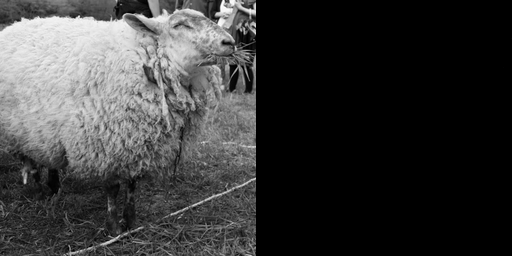

In [22]:
display(input, output)

In [23]:
conv.weight.data

tensor([[[[-0.1696, -0.2509,  0.0891],
          [-0.0360, -0.0053, -0.2824],
          [ 0.1406, -0.2789, -0.2083]]]])

In [24]:
conv.weight.shape

torch.Size([1, 1, 3, 3])

## Identity

In [25]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

In [26]:
conv.weight.data

tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]])

In [27]:
output = conv(input)

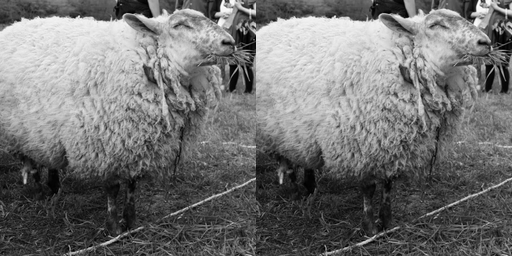

In [28]:
display(input, output)

## Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


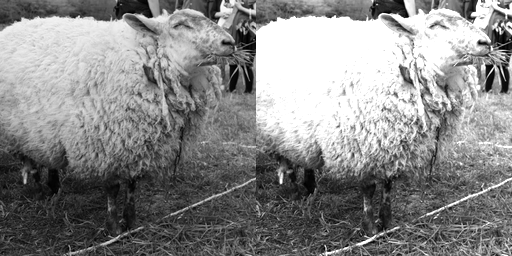

In [29]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

## Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


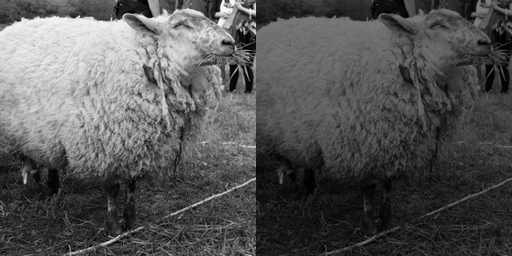

In [30]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

## Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


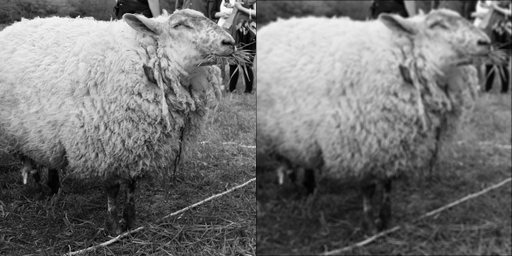

In [31]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

## Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


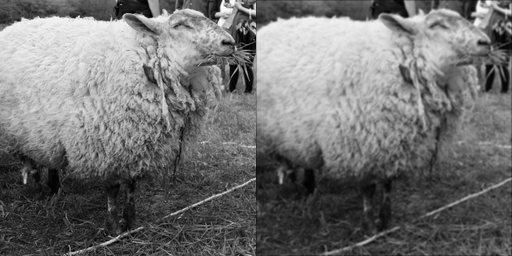

In [32]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

## Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


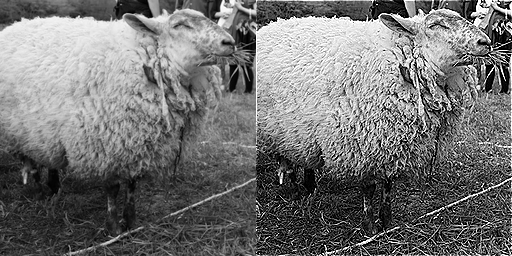

In [33]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


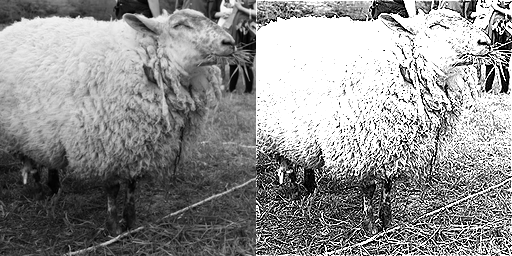

In [34]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

## Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


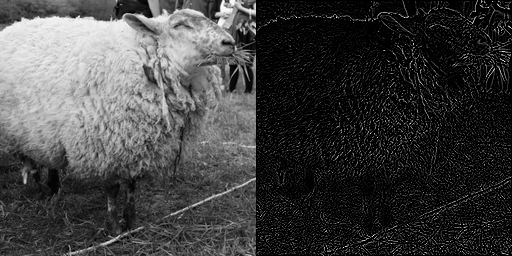

In [35]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

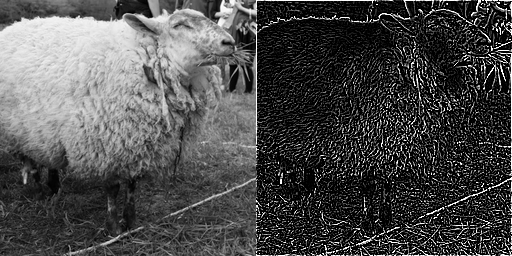

In [36]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

In [ ]:
# https://github.com/chokkan/deeplearning/blob/master/notebook/convolution.ipynb